In [1]:
import quadpy
import scipy
import shapely

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = "retina"

### Functions and constants

In [2]:
LINEWIDTH = 0.5
LEVELS = np.linspace(-0.5, 0.5, 11)


def kelvin_point_source(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    kelvin_displacements = np.zeros((len(x), 2))
    kelvin_stresses = np.zeros((len(x), 3))
    C = 1 / (4 * np.pi * (1 - nu))
    r = np.sqrt(x**2 + y**2)
    g = -C * np.log(r)
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    gxy = C * 2 * x * y / (x**2 + y**2) ** 2
    gxx = C * (x**2 - y**2) / (x**2 + y**2) ** 2
    gyy = -gxx
    kelvin_displacements[:, 0] = fx / (2 * mu) * ((3 - 4 * nu) * g - x * gx) + fy / (
        2 * mu
    ) * (-y * gx)
    kelvin_displacements[:, 1] = fx / (2 * mu) * (-x * gy) + fy / (2 * mu) * (
        (3 - 4 * nu) * g - y * gy
    )
    kelvin_stresses[:, 0] = fx * (2 * (1 - nu) * gx - x * gxx) + fy * (
        2 * nu * gy - y * gxx
    )
    kelvin_stresses[:, 1] = fx * (2 * nu * gx - x * gyy) + fy * (
        2 * (1 - nu) * gy - y * gyy
    )
    kelvin_stresses[:, 2] = fx * ((1 - 2 * nu) * gy - x * gxy) + fy * (
        (1 - 2 * nu) * gx - y * gxy
    )
    return kelvin_displacements, kelvin_stresses


def kelvin_point_source_disp(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    C = 1 / (4 * np.pi * (1 - nu))
    r = np.sqrt(x**2 + y**2)
    g = -C * np.log(r)
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    ux = fx / (2 * mu) * ((3 - 4 * nu) * g - x * gx) + fy / (2 * mu) * (-y * gx)
    uy = fx / (2 * mu) * (-x * gy) + fy / (2 * mu) * ((3 - 4 * nu) * g - y * gy)
    return ux, uy


def kelvin_point_source_stress(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    C = 1 / (4 * np.pi * (1 - nu))
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    gxy = C * 2 * x * y / (x**2 + y**2) ** 2
    gxx = C * (x**2 - y**2) / (x**2 + y**2) ** 2
    gyy = -gxx
    sxx = fx * (2 * (1 - nu) * gx - x * gxx) + fy * (2 * nu * gy - y * gxx)
    syy = fx * (2 * nu * gx - x * gyy) + fy * (2 * (1 - nu) * gy - y * gyy)
    sxy = fx * ((1 - 2 * nu) * gy - x * gxy) + fy * ((1 - 2 * nu) * gx - y * gxy)
    return sxx, syy, sxy


def get_triangle_area(lx, ly, dly):

    # Calculate the lengths of the sides of the triangle
    a = np.sqrt((lx - 0) ** 2 + (dly - 0) ** 2)
    b = np.sqrt((0 - lx) ** 2 + (ly - dly) ** 2)
    c = np.sqrt((0 - 0) ** 2 + (0 - ly) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    triangle_area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return triangle_area


def plot_stresses(x_grid, y_grid, stresses, triangle, title_string):
    plt.contourf(
        x_grid,
        y_grid,
        stresses,
        cmap="coolwarm",
        levels=LEVELS,
    )
    plt.colorbar(fraction=0.026, pad=0.04, extend="both")
    plt.clim([-0.5, 0.5])
    plt.contour(
        x_grid,
        y_grid,
        stresses,
        colors="gray",
        linestyles="solid",
        linewidths=LINEWIDTH,
        levels=LEVELS,
    )
    plt.fill(triangle[:, 0], triangle[:, 1], facecolor="None", edgecolor="k")
    plt.title(title_string)
    plt.gca().set_aspect("equal")
    plt.xlim([np.min(x_grid), np.max(x_grid)])
    plt.ylim([np.min(y_grid), np.max(y_grid)])

### Parameters:
- Triangle geometry
- Forcing
- Material constants
- Observation coordinates

[0. 1. 0.]


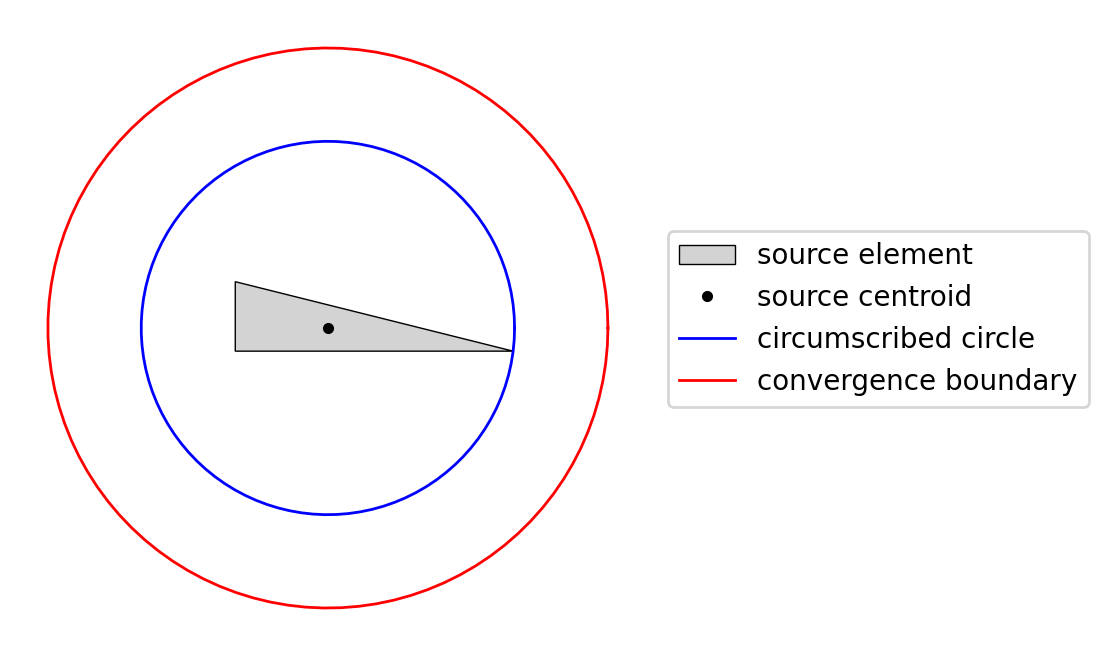

In [75]:
triangle_original = np.array([[0.0, 0.0], [1.0, 0.5], [0.0, 1.0]])
triangle_original = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 0.25]])
triangle = np.copy(triangle_original)

# Find triangle centroid
triangle_centroid_x = np.mean(triangle[:, 0])
triangle_centroid_y = np.mean(triangle[:, 1])

# Find point farthest from triangle centroid
triangle_vertex_distances_from_centroid = scipy.spatial.distance.cdist(
    np.array([triangle_centroid_x, triangle_centroid_y])[:, None].T, triangle
)
circle_radius_circumscribed = np.max(triangle_vertex_distances_from_centroid)


def calculate_circle_points(center_x, center_y, radius, n_pts=100):
    angles = np.linspace(0, 2.0 * np.pi, n_pts)
    circle_x = radius * np.cos(angles) + center_x
    circle_y = radius * np.sin(angles) + center_y
    return circle_x, circle_y


circle_perimeter_circumscribed_x, circle_perimeter_circumscribed_y = (
    calculate_circle_points(
        triangle_centroid_x, triangle_centroid_y, circle_radius_circumscribed, n_pts=100
    )
)

circle_perimeter_enlarged_x, circle_perimeter_enlarged_y = calculate_circle_points(
    triangle_centroid_x,
    triangle_centroid_y,
    1.5 * circle_radius_circumscribed,
    n_pts=100,
)

# Plot triangle and enclosing circle
plt.figure(figsize=(4, 4))
plt.fill(
    triangle[:, 0],
    triangle[:, 1],
    facecolor="lightgray",
    edgecolor="k",
    linewidth=0.5,
    label="source element",
)

plt.plot(triangle_centroid_x, triangle_centroid_y, ".k", label="source centroid")

plt.plot(
    circle_perimeter_circumscribed_x,
    circle_perimeter_circumscribed_y,
    "-b",
    linewidth=1.0,
    label="circumscribed circle",
)

plt.plot(
    circle_perimeter_enlarged_x,
    circle_perimeter_enlarged_y,
    "-r",
    linewidth=1.0,
    label="convergence boundary",
)

plt.legend(bbox_to_anchor=(1.03, 0.68), loc="upper left")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.show()

# Find vertex with smallest x-value and translate to the origin
# min_x_vertex_idx =


x_offset = 0.0
y_offset = 0.0
fx = 0.0
fy = 1.0
mu = 1.0
nu = 0.25
n_obs = 20
x_vec = np.linspace(-0.5, 1.5, n_obs)
y_vec = np.linspace(-0.5, 1.5, n_obs)
x_grid, y_grid = np.meshgrid(x_vec, y_vec)

#### Fast far-field integration with `quadpy`

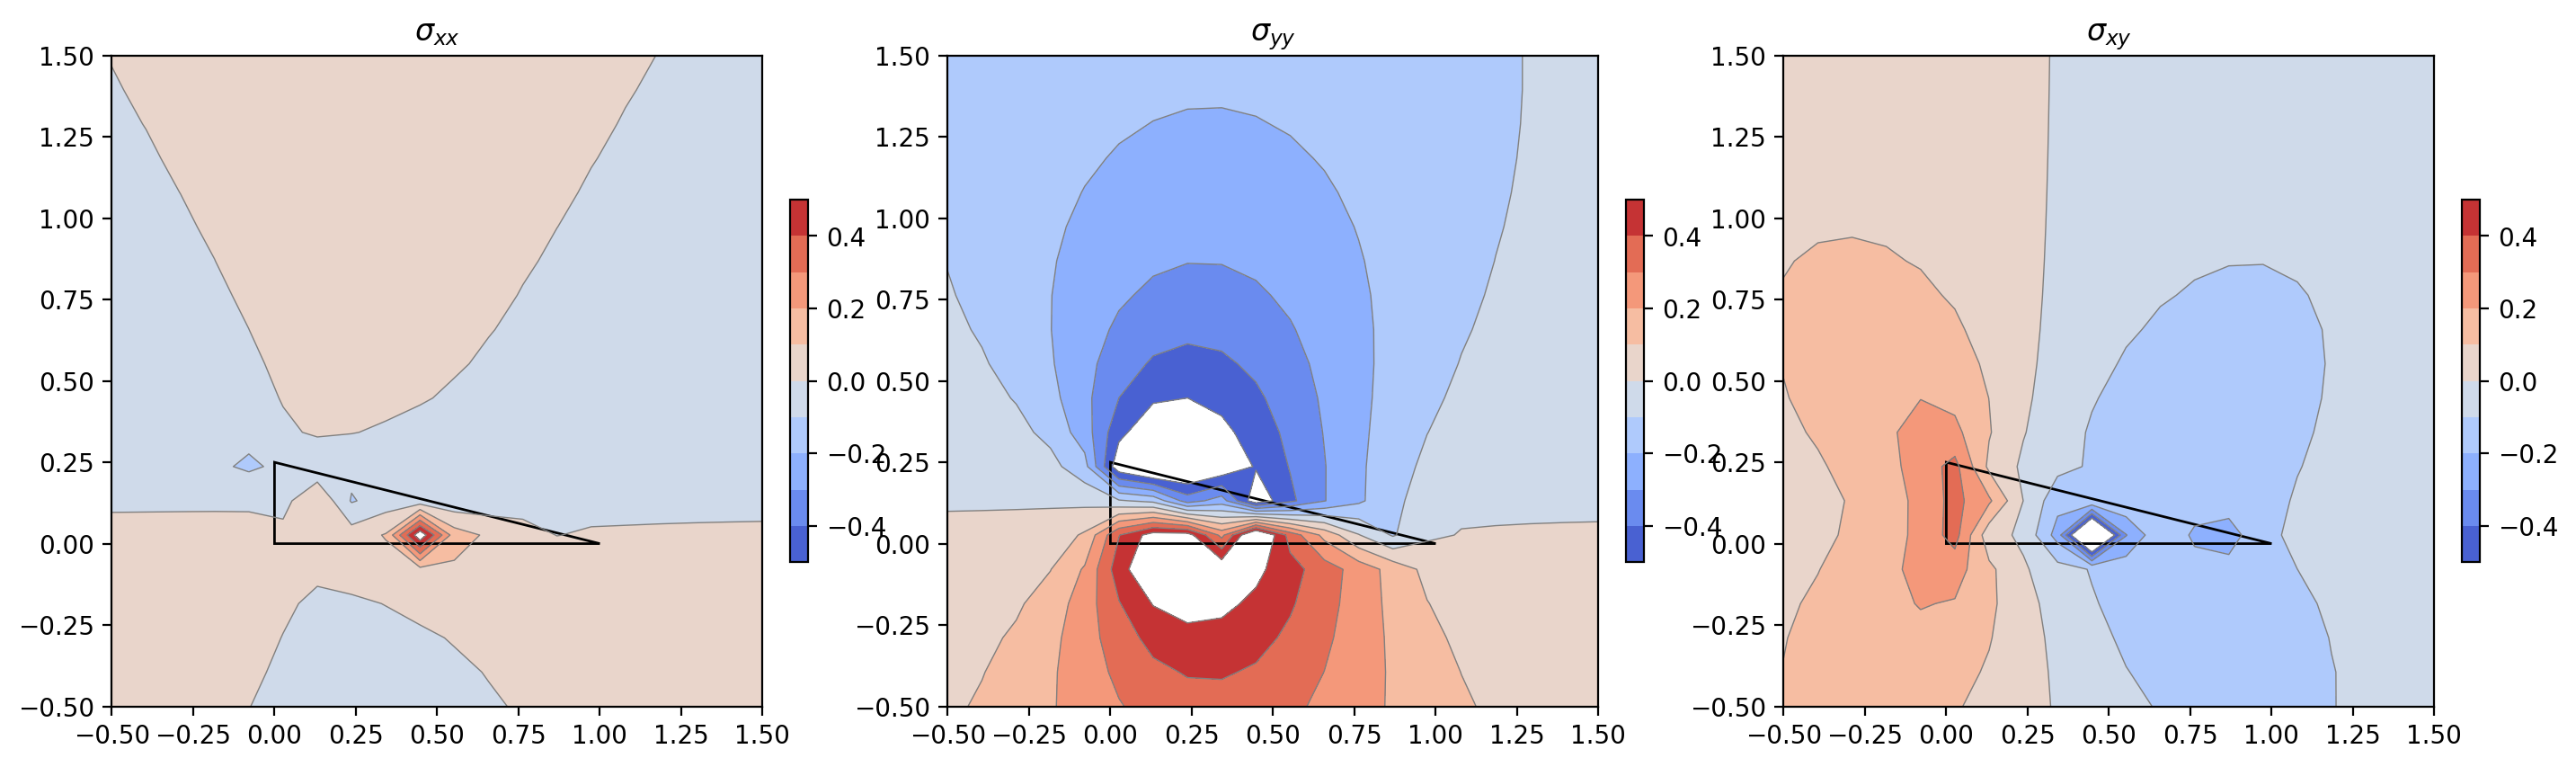

In [4]:
# quadpy integration scheme
scheme = quadpy.t2.get_good_scheme(20)
points_new = np.dot(triangle.T, scheme.points)
n_integration_pts = len(scheme.weights)

# quadpy integration
kelvin_displacements = np.zeros((n_obs**2, 2))
kelvin_stresses = np.zeros((n_obs**2, 3))
for i in range(n_integration_pts):
    x_offset = points_new[0, i]
    y_offset = points_new[1, i]
    kelvin_displacements_local, kelvin_stresses_local = kelvin_point_source(
        x_grid.flatten(), y_grid.flatten(), x_offset, y_offset, fx, fy, mu, nu
    )
    kelvin_displacements += scheme.weights[i] * kelvin_displacements_local
    kelvin_stresses += scheme.weights[i] * kelvin_stresses_local

sxx_quadpy = kelvin_stresses[:, 0]
syy_quadpy = kelvin_stresses[:, 1]
sxy_quadpy = kelvin_stresses[:, 2]


# Stress plotting
plt.figure(figsize=(17, 6))
plt.subplot(1, 3, 1)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(sxx_quadpy, (n_obs, n_obs)),
    triangle,
    "$\sigma_{xx}$",
)
plt.subplot(1, 3, 2)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(syy_quadpy, (n_obs, n_obs)),
    triangle,
    "$\sigma_{yy}$",
)
plt.subplot(1, 3, 3)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(sxy_quadpy, (n_obs, n_obs)),
    triangle,
    "$\sigma_{xy}$",
)
plt.show()

### `scipy.integrate.dblquad` integration
- The triangle $ABC$ is defined in terms of: $A(0,0)$, $B(L_x,dL_y)$, $C(0,L_y)$

1.0 0.25 0.0


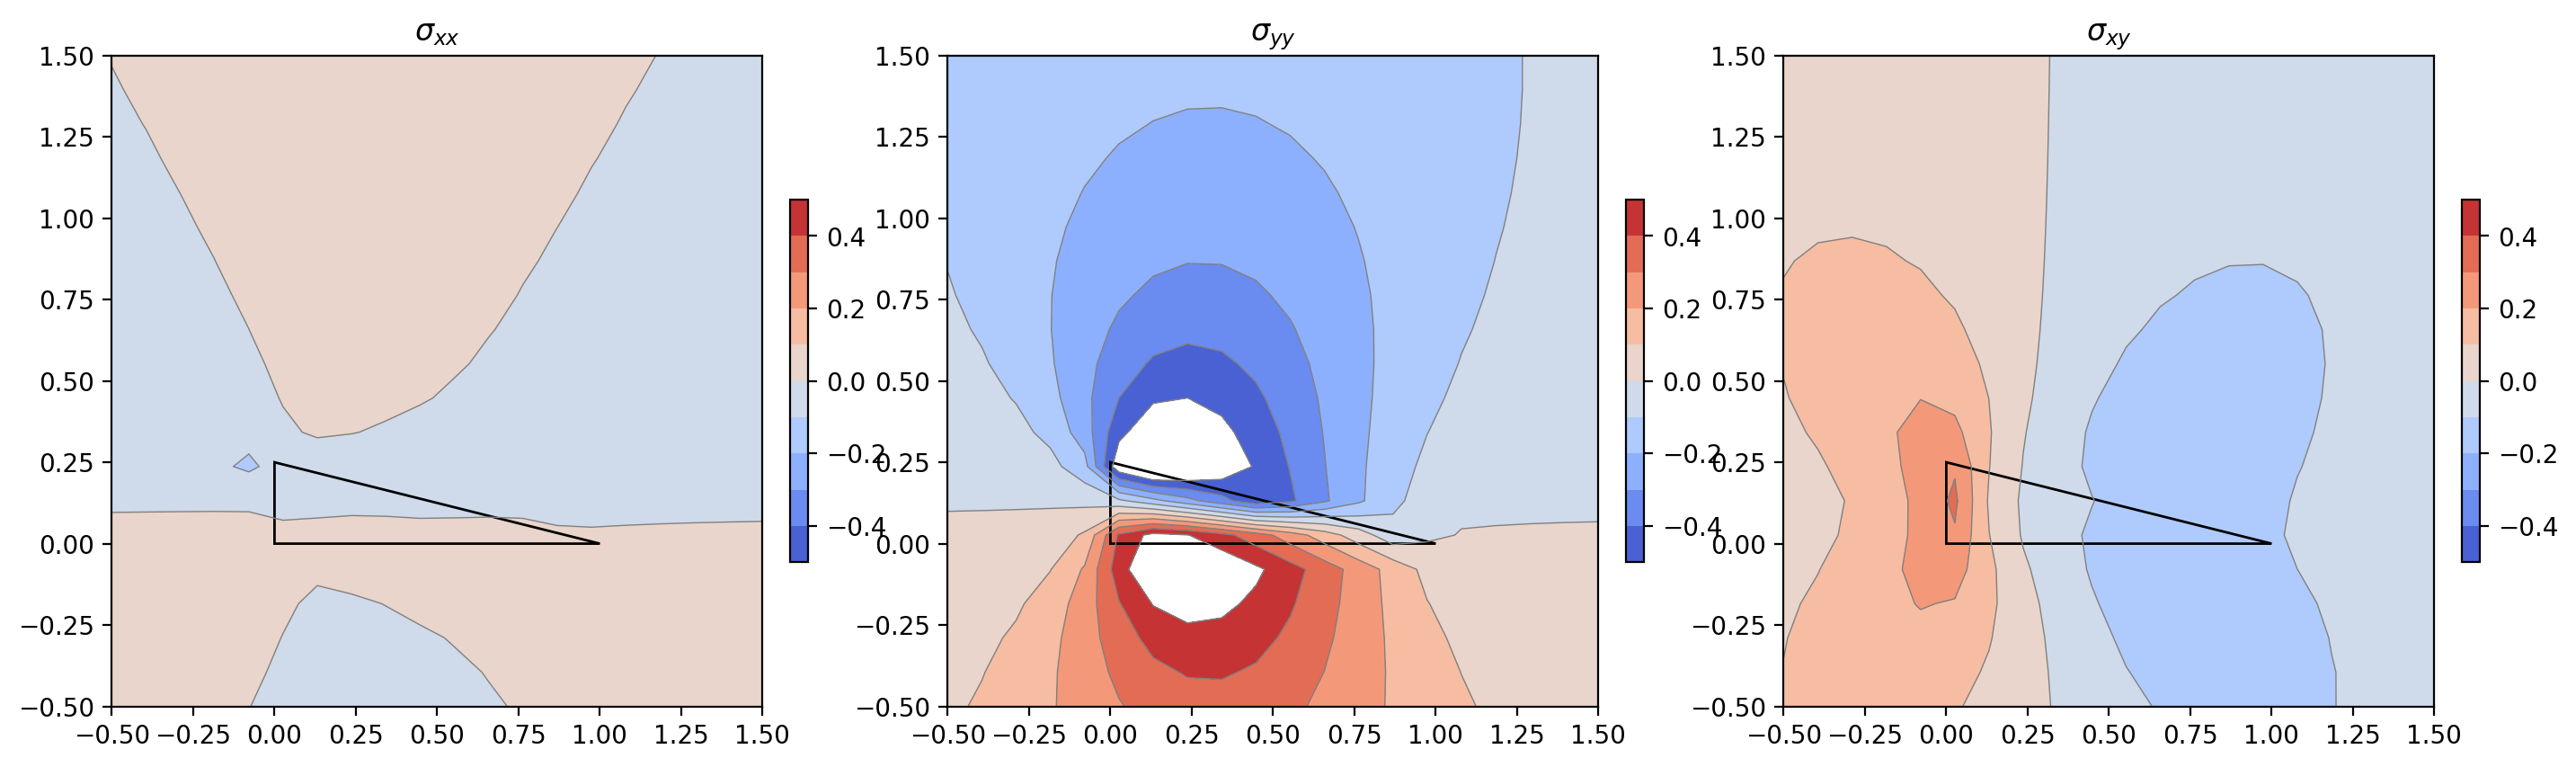

In [5]:
# Define a triangle region
# triangle = np.array([[0.0, 0.0], [1.0, 0.5], [0.0, 1.0]])

lx = triangle[1, 0]
ly = triangle[2, 1]
dly = triangle[1, 1]

print(lx, ly, dly)

# lx = 1
# ly = 1
# dly = 0.0
triangle_area = get_triangle_area(lx, ly, dly)

# Definition of integration limits over a triangle
ymin = lambda x: dly * x / lx
ymax = lambda x: ly - (ly - dly) * x / lx

sxx_dblquad = np.zeros_like(x_grid).flatten()
syy_dblquad = np.zeros_like(x_grid).flatten()
sxy_dblquad = np.zeros_like(x_grid).flatten()

for i in range(0, x_grid.size):
    # xx stress integration
    f = lambda y, x: kelvin_point_source_stress(
        x_grid.flatten()[i], y_grid.flatten()[i], x, y, fx, fy, mu, nu
    )[0]
    sol, err = scipy.integrate.dblquad(f, 0, 1, ymin, ymax, epsabs=1e-3)
    sxx_dblquad[i] = sol / triangle_area

    # yy stress integration
    f = lambda y, x: kelvin_point_source_stress(
        x_grid.flatten()[i], y_grid.flatten()[i], x, y, fx, fy, mu, nu
    )[1]
    sol, err = scipy.integrate.dblquad(f, 0, 1, ymin, ymax, epsabs=1e-3)
    syy_dblquad[i] = sol / triangle_area

    # xy stress integration
    f = lambda y, x: kelvin_point_source_stress(
        x_grid.flatten()[i], y_grid.flatten()[i], x, y, fx, fy, mu, nu
    )[2]
    sol, err = scipy.integrate.dblquad(f, 0, 1, ymin, ymax, epsabs=1e-3)
    sxy_dblquad[i] = sol / triangle_area


plt.figure(figsize=(17, 6))
plt.subplot(1, 3, 1)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(sxx_dblquad, (n_obs, n_obs)),
    triangle,
    "$\sigma_{xx}$",
)

plt.subplot(1, 3, 2)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(syy_dblquad, (n_obs, n_obs)),
    triangle,
    "$\sigma_{yy}$",
)

plt.subplot(1, 3, 3)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(sxy_dblquad, (n_obs, n_obs)),
    triangle,
    "$\sigma_{xy}$",
)
plt.show()

### Plot residual stresses

/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_50791/1550270593.py:5: RuntimeWarning: divide by zero encountered in log10
  sxx_residual = np.log10(np.abs(sxx_residual))
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_50791/1550270593.py:15: RuntimeWarning: divide by zero encountered in log10
  sxy_residual = np.log10(np.abs(sxy_residual))


(-0.5, 1.5)

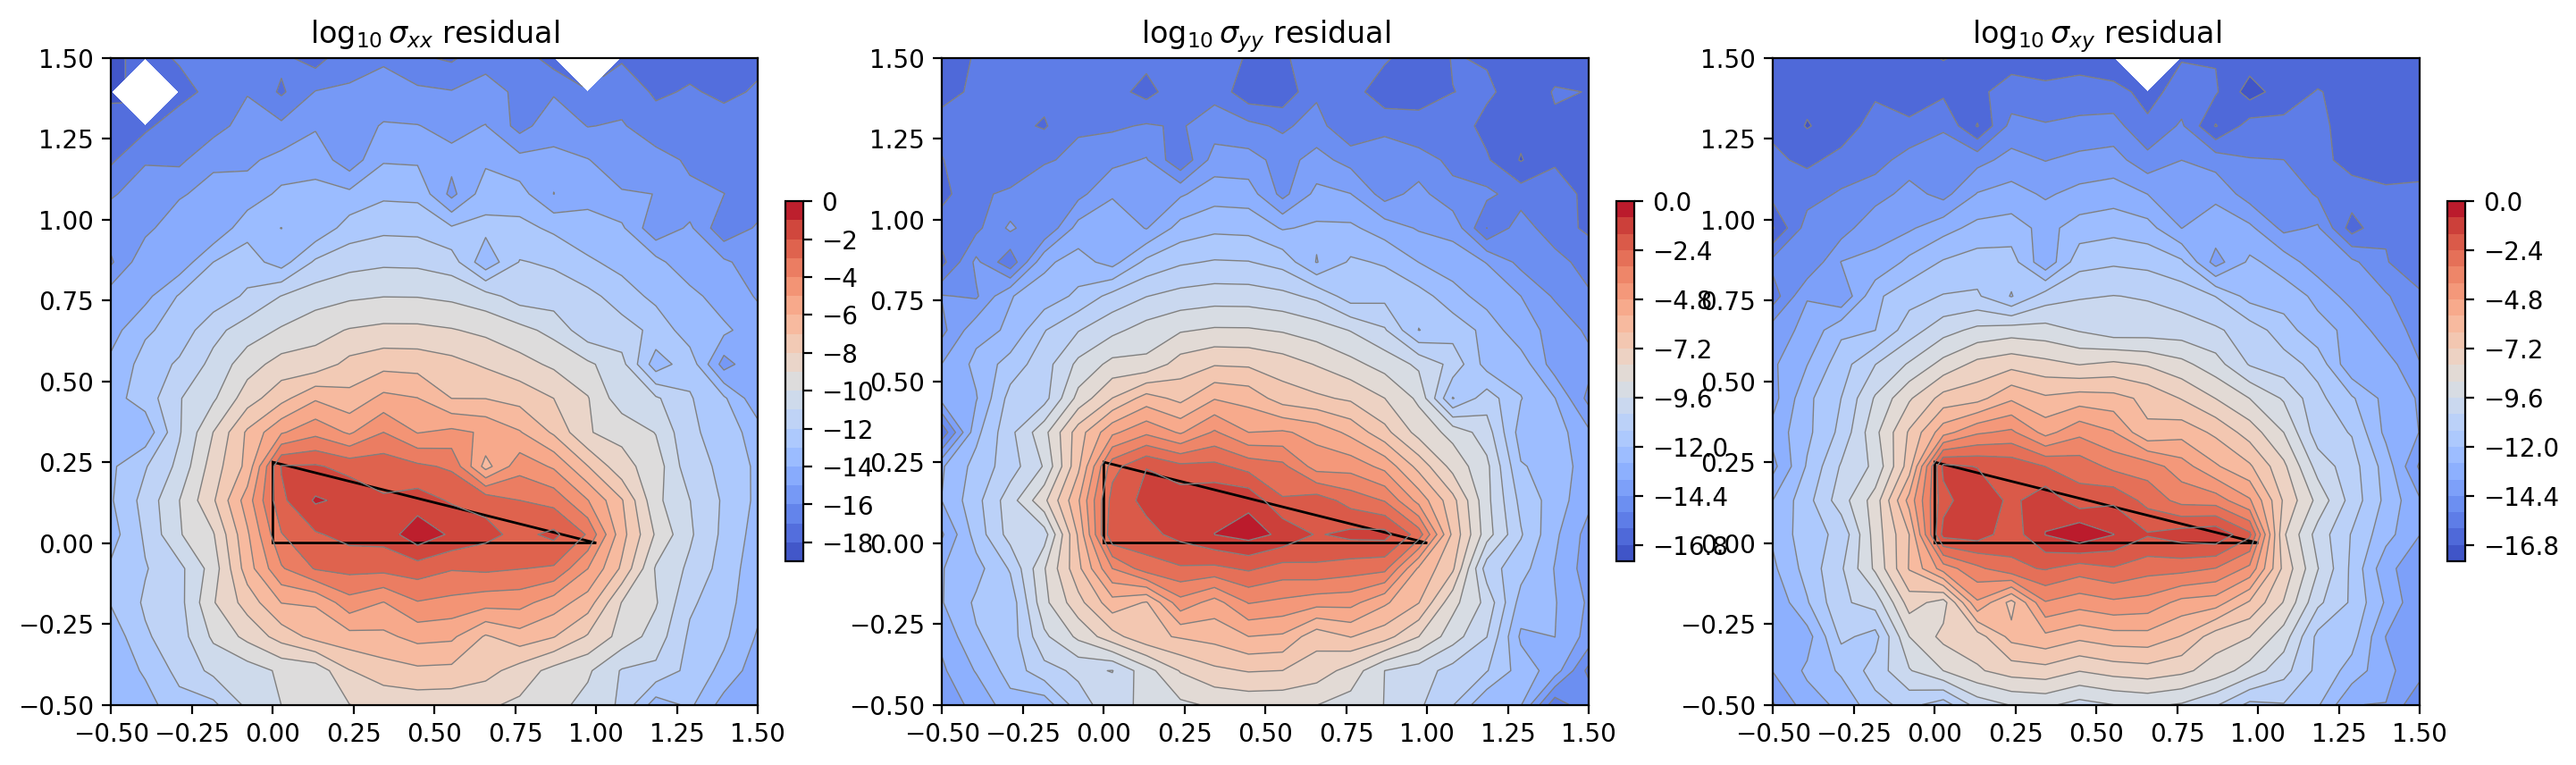

In [6]:
LEVELS_RESIDUAL = 21
sxx_residual = np.reshape(sxx_dblquad, (n_obs, n_obs)) - np.reshape(
    sxx_quadpy, (n_obs, n_obs)
)
sxx_residual = np.log10(np.abs(sxx_residual))

syy_residual = np.reshape(syy_dblquad, (n_obs, n_obs)) - np.reshape(
    syy_quadpy, (n_obs, n_obs)
)
syy_residual = np.log10(np.abs(syy_residual))

sxy_residual = np.reshape(sxy_dblquad, (n_obs, n_obs)) - np.reshape(
    sxy_quadpy, (n_obs, n_obs)
)
sxy_residual = np.log10(np.abs(sxy_residual))

plt.figure(figsize=(17, 6))
plt.subplot(1, 3, 1)
plt.contourf(
    x_grid,
    y_grid,
    sxx_residual,
    cmap="coolwarm",
    levels=LEVELS_RESIDUAL,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.contour(
    x_grid,
    y_grid,
    sxx_residual,
    colors="gray",
    linestyles="solid",
    linewidths=LINEWIDTH,
    levels=LEVELS_RESIDUAL,
)
plt.fill(triangle[:, 0], triangle[:, 1], facecolor="None", edgecolor="k")
plt.title("$\log_{10}\sigma_{xx}$ residual")
plt.gca().set_aspect("equal")
plt.xlim([np.min(x_grid), np.max(x_grid)])
plt.ylim([np.min(y_grid), np.max(y_grid)])


plt.subplot(1, 3, 2)
plt.contourf(
    x_grid,
    y_grid,
    syy_residual,
    cmap="coolwarm",
    levels=LEVELS_RESIDUAL,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.contour(
    x_grid,
    y_grid,
    syy_residual,
    colors="gray",
    linestyles="solid",
    linewidths=LINEWIDTH,
    levels=LEVELS_RESIDUAL,
)
plt.fill(triangle[:, 0], triangle[:, 1], facecolor="None", edgecolor="k")
plt.title("$\log_{10}\sigma_{yy}$ residual")
plt.gca().set_aspect("equal")
plt.xlim([np.min(x_grid), np.max(x_grid)])
plt.ylim([np.min(y_grid), np.max(y_grid)])


plt.subplot(1, 3, 3)
plt.contourf(
    x_grid,
    y_grid,
    sxy_residual,
    cmap="coolwarm",
    levels=LEVELS_RESIDUAL,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.contour(
    x_grid,
    y_grid,
    sxy_residual,
    colors="gray",
    linestyles="solid",
    linewidths=LINEWIDTH,
    levels=LEVELS_RESIDUAL,
)
plt.fill(triangle[:, 0], triangle[:, 1], facecolor="None", edgecolor="k")
plt.title("$\log_{10}\sigma_{xy}$ residual")
plt.gca().set_aspect("equal")
plt.xlim([np.min(x_grid), np.max(x_grid)])
plt.ylim([np.min(y_grid), np.max(y_grid)])

# TODO: Near-field vs. far field with shapely buffering?
- https://shapely.readthedocs.io/en/stable/

In [7]:
# define an equilateral triangle as LinearRing (just to make sure than all three corners are comparable
lr = shapely.geometry.LinearRing([[0, 0], [50, (100**2 - 50**2) ** 0.5], [100, 0]])
print(lr.is_closed)  # is closed as expected
print(list(lr.coords))  # the three given coordinates plus the closing [0, 0]
lr_buffered = lr.buffer(2, 2)
print(
    list(lr_buffered.exterior.coords)
)  # UNEXPECTED: more vertices than expected around [0, 0]

# x,y = lr.exterior.xy
# plt.plot(x,y)

True
[(0.0, 0.0), (50.0, 86.60254037844386), (100.0, 0.0), (0.0, 0.0)]
[(0.0, -2.0), (-1.285575219373079, -1.5320888862379558), (-1.9696155060244163, -0.34729635533386005), (-1.7320508075688772, 1.0), (48.267949192431125, 87.60254037844386), (49.31595971334866, 88.48192562001567), (50.68404028665134, 88.48192562001567), (51.732050807568875, 87.60254037844386), (101.73205080756888, 1.0), (101.96961550602441, -0.34729635533386227), (101.28557521937307, -1.5320888862379567), (100.0, -2.0), (0.0, -2.0)]


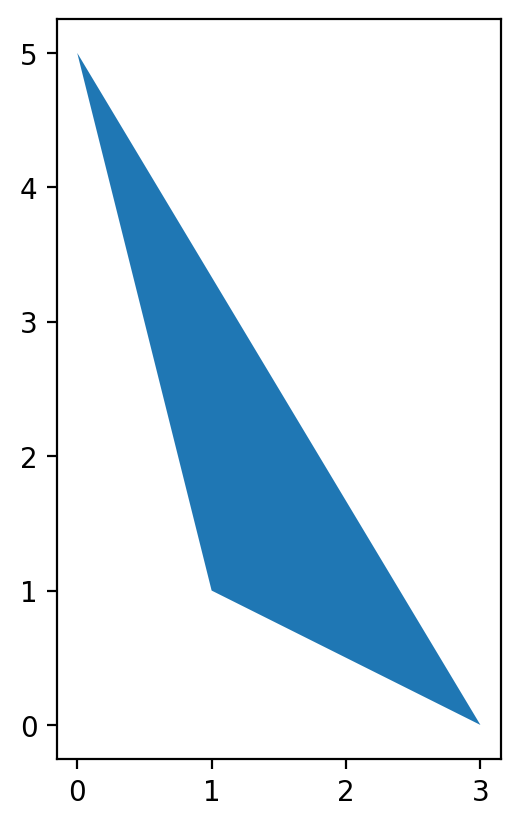

In [8]:
polygon1 = shapely.geometry.Polygon(
    [
        (0, 5),
        (1, 1),
        (3, 0),
    ]
)

p = gpd.GeoSeries(polygon1)
p.plot()
plt.show()

<Axes: >

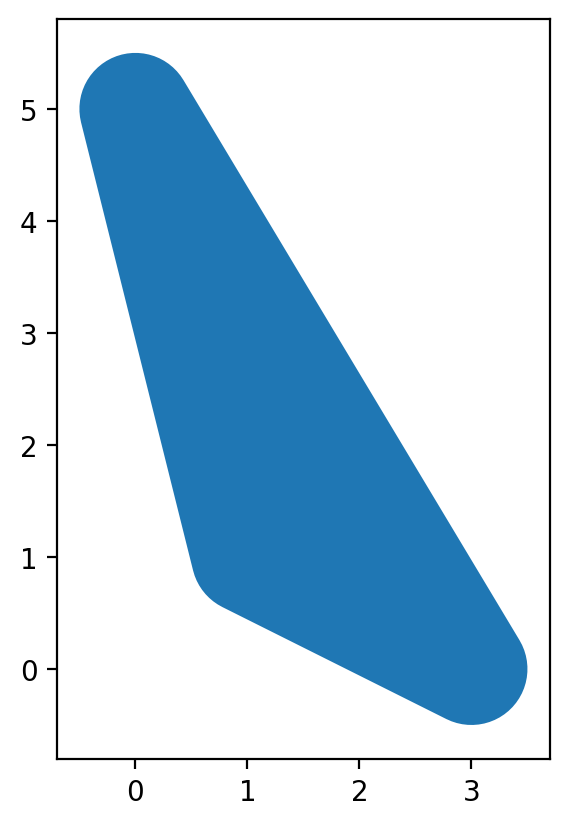

In [9]:
pp = p.buffer(0.5)
# p = gpd.GeoSeries(polygon1)
pp.plot()
# plt.show()

In [10]:
xx, yy = polygon1.exterior.coords.xy

In [11]:
polygon1.exterior.coords[:]

[(0.0, 5.0), (1.0, 1.0), (3.0, 0.0), (0.0, 5.0)]

In [12]:
# from shapely.geometry import Point, Polygon
# from shapely.affinity import translate
# import math


# # Function to create an equilateral triangle
# def create_equilateral_triangle(center_x, center_y, side_length):
#     height = math.sqrt(3) / 2 * side_length
#     p1 = (center_x, center_y + 2 / 3 * height)
#     p2 = (center_x - side_length / 2, center_y - 1 / 3 * height)
#     p3 = (center_x + side_length / 2, center_y - 1 / 3 * height)
#     return Polygon([p1, p2, p3])


# # Function to check if a point is inside the buffered triangle
# def is_point_inside_buffered_triangle(triangle, buffer_distance, point):
#     buffered_triangle = triangle.buffer(buffer_distance)
#     return buffered_triangle.contains(point)


# # Create an equilateral triangle with center at (0, 0) and side length of 1 unit
# triangle = create_equilateral_triangle(0, 0, 1)

# # Calculate a buffer of 0.1 units around the triangle
# buffer_distance = 0.1

# # Create a point to check
# point = Point(0.1, 0.1)

# # Check if the point is inside the buffered triangle
# is_inside = is_point_inside_buffered_triangle(triangle, buffer_distance, point)

# print(f"The point {point} is inside the buffered triangle: {is_inside}")

In [13]:
# Find vertex closest to origin???
idx = np.where(triangle[:, 0] == np.min(triangle[:, 0]))[0]
if len(idx) > 1:
    same_x_vertices = triangle[idx, :]
    idx_same_x_vertices = np.where(
        same_x_vertices[:, 1] == np.min(same_x_vertices[:, 1])
    )[0]
    idx = idx[idx_same_x_vertices]

print(triangle[idx, :])

[[0. 0.]]


In [14]:
# DONE: Find triangle centroid
# TODO: Generate synthetic observation points based on triangle vertices
# TODO: Translate and rotated triangle to get the correct edge alignment
# TODO: Integration in translated and rotated space
# TODO: Project stresses and displacements back to unrotated space
# TODO: Buffer rule

In [15]:
triangle_x_centroid = np.mean(np.sum(triangle[:, 0]))
triangle_y_centroid = np.mean(np.sum(triangle[:, 1]))
print(triangle_x_centroid, triangle_y_centroid)

1.0 0.25


In [18]:
# from scipy.spatial import distance

coords = [
    (35.0456, -85.2672),
    (35.1174, -89.9711),
    (35.9728, -83.9422),
    (36.1667, -86.7833),
]
scipy.spatial.distance.cdist(coords, coords, "euclidean")

array([[0.        , 4.70444794, 1.6171966 , 1.88558331],
       [4.70444794, 0.        , 6.0892811 , 3.35605413],
       [1.6171966 , 6.0892811 , 0.        , 2.84770898],
       [1.88558331, 3.35605413, 2.84770898, 0.        ]])